In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
from celldreamer.eval.evaluate import compute_prdc
import scipy.sparse as sp

from torch import nn
import scanpy as sc    
import muon as mu

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


**Util function**

In [2]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

## Step 1: Initialize data

In [3]:
dataset_config = {"dataset_path": DATA_DIR / "processed" / "atac" / "pbmc10k_multiome.h5mu",
                    "layer_key": "X_counts",
                    "covariate_keys": ["cell_type"],
                    "conditioning_covariate": "cell_type",
                    "subsample_frac": 1,
                    "encoder_type": "learnt_autoencoder",
                    "target_max": 1,
                    "target_min": -1,
                    "one_hot_encode_features": False,
                    "split_rates": [0.80, 0.10, 0.10],
                    "cov_embedding_dimensions": 100,
                    "multimodal": True,
                    "is_binarized": True
                }

data_path = dataset_config["dataset_path"]
dataset = RNAseqLoader(data_path = data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        target_max=dataset_config["target_max"], 
                        target_min=dataset_config["target_min"], 
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


learnt_autoencoder
learnt_autoencoder


## Step 2: Initialize encoder

In [4]:
encoder_config = {
    "x0_from_x_kwargs": {
        "rna": {
            "dims": [512, 300, 100],
            "batch_norm": True,
            "dropout": False,
            "dropout_p": 0.0
        },
        "atac": {
            "dims": [1024, 512, 100],
            "batch_norm": True,
            "dropout": False,
            "dropout_p": 0.0
        }
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False,
    "multimodal": True,
    "is_binarized": True
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_pbmc10k_multimodal/21550052-1fed-448e-8d77-d3ca58e466cf/checkpoints/last.ckpt"

In [5]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}
modality_list = list(gene_dim.keys())
in_dim = {}

for mod in dataset.X:
    if dataset_config["encoder_type"]!="learnt_autoencoder":
        in_dim[mod] = gene_dim[mod]
    else:
        in_dim[mod] = encoder_config["x0_from_x_kwargs"][mod]["dims"][-1]
                    
size_factor_statistics = {"mean": {mod: dataset.log_size_factor_mu[mod] for mod in dataset.log_size_factor_mu}, 
                            "sd": {mod: dataset.log_size_factor_sd[mod] for mod in dataset.log_size_factor_sd}}

scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["cell_type"])

In [6]:
encoder_model = EncoderModel(in_dim=gene_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): ModuleDict(
    (rna): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=25604, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=300, bias=True)
          (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=300, out_features=100, bias=True)
      )
    )
    (atac): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=40086, out_features=1024, bias=True)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=512, bias=True)
         

## Initialize FM model

In [7]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [8]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_pbmc10k/5fb4f508-bdec-430c-8b16-be2999acb820/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model

MLPTimeStep(
  (time_embedder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (size_factor_embedder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (condition_embedder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (net_in): Linear(in_features=200, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x ResnetBlock(
      (net1): Sequential(
        (0): SiLU()
        (1): Linear(in_features=64, out_features=64, bias=True)
      )
      (cond_proj): Sequential(
        (0): SiLU()
        (1): Linear(in_features=128, out_features=64, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=64, out_features=

In [9]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 6.3474e-01, -1.7591e-01, -1.3633e+00,  2.5294e-01, -1.4965e-01,
         -1.1841e+00,  1.1062e-01, -1.3359e-01,  1.5223e+00, -1.7654e-01,
          2.1099e-01, -9.8331e-01,  2.7712e-01,  1.1709e+00,  1.1022e+00,
          4.8634e-01,  4.3924e-01, -3.1385e-02,  2.7809e-01,  1.0635e+00,
          2.1689e-01, -2.1317e+00,  1.1188e+00,  1.1884e+00,  2.7638e-01,
         -5.4153e-01, -2.0333e+00,  2.1072e+00, -4.9244e-01,  6.6381e-01,
          1.3013e+00,  7.8117e-01],
        [-3.0753e-01, -1.1163e+00,  9.1965e-02,  1.1509e+00, -5.2448e-01,
          4.7327e-01,  1.1226e+00,  1.4940e-01,  1.6622e-01, -5.7493e-01,
          1.9663e+00,  5.4037e-01,  3.4105e-01, -8.6918e-01,  8.3691e-01,
          1.1025e+00, -1.4312e-01,  4.2073e-01, -6.9065e-01, -5.4399e-01,
          1.0378e+00,  4.4115e-01,  1.2953e-01, -2.9610e-01, -1.5816e+00,
         -1.0499e+00,  2.0518e-01, -9.2399e-03,  4.0509e-01,  7.6869e-01,
         -8.5416e-01,  7.8183e-01],
        [-2.1422e-

Initializations

In [10]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            multimodal=dataset_config["multimodal"],
            is_binarized=dataset_config["is_binarized"], 
            modality_list=modality_list,
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=25604, out_features=512, bias=True)
            (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
            (0): Linear(in_features=512, out_features=300, bias=True)
            (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (2): Linear(in_features=300, out_features=100, bias=True)
        )
      )
      (atac): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=40086, out_features=1024, bias=True)
            (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
       

**Check the data**

In [11]:
adata_original = mu.read(data_path)
adata_rna = adata_original.mod["rna"]
adata_atac = adata_original.mod["atac"]
adata_rna.obs["size_factor"]=adata_rna.X.A.sum(1)
adata_atac.obs["size_factor"]=adata_atac.X.A.sum(1)
X_rna = torch.tensor(adata_rna.layers["X_counts"].todense())
X_atac = torch.tensor(adata_atac.layers["X_counts"].todense())

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [12]:
adata_rna

AnnData object with n_obs × n_vars = 10000 × 25604
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'size_factor'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

In [100]:
adata_atac.obs.cell_type = adata_rna.obs.cell_type

**Collect checkpoints and run**

General conditional

In [77]:
X_generated_list_rna = []
X_generated_list_atac = []

classes_str = []

for _ in tqdm(range(10)):
    num_indices =1000
    index_range = len(X_rna)
    
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), num_indices)
    adata_rna_indices = adata_rna[indices]
    adata_atac_indices = adata_atac[indices]
    
    classes =  list(adata_rna_indices.obs.cell_type)
    classes_str += classes
    classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes]).cuda()

    # log_size_factors = {"rna": torch.log(torch.tensor(adata_rna_indices.layers["X_counts"].sum(1))).cuda(),
    #                     "atac": torch.log(torch.tensor(adata_atac_indices.layers["X_counts"].sum(1))).cuda()}
    log_size_factors = torch.log(torch.tensor(adata_rna_indices.layers["X_counts"].sum(1))).cuda()
    
    X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=10,
                                                n_sample_steps=2, 
                                                covariate="cell_type", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

    X_generated_list_rna.append(X_generated["rna"].to("cpu"))
    X_generated_list_atac.append(X_generated["atac"].to("cpu"))

100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


In [78]:
X_generated_rna_list = torch.cat(X_generated_list_rna, dim=0)
X_generated_atac_list = torch.cat(X_generated_list_atac, dim=0)

In [79]:
# X_generated_list.shape

Single condition

In [80]:
# dataset.id2cov["cell_type"]

In [81]:
# # Pick condition 
# condition_name = "Normoblast"
# condition_val = dataset.id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [82]:
# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [83]:
adata_generated_rna = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_rna_list).cpu().numpy()))
adata_generated_rna.obs["size_factor"] = adata_generated_rna.X.sum(1)
adata_generated_atac = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_atac_list).cpu().numpy()))
adata_generated_atac.obs["size_factor"] = adata_generated_atac.X.sum(1)

In [84]:
sc.pp.log1p(adata_generated_rna)
sc.tl.pca(adata_generated_rna)
sc.pp.neighbors(adata_generated_rna)
sc.tl.umap(adata_generated_rna)

In [85]:
sc.pp.log1p(adata_generated_atac)
sc.tl.pca(adata_generated_atac)
sc.pp.neighbors(adata_generated_atac)
sc.tl.umap(adata_generated_atac)

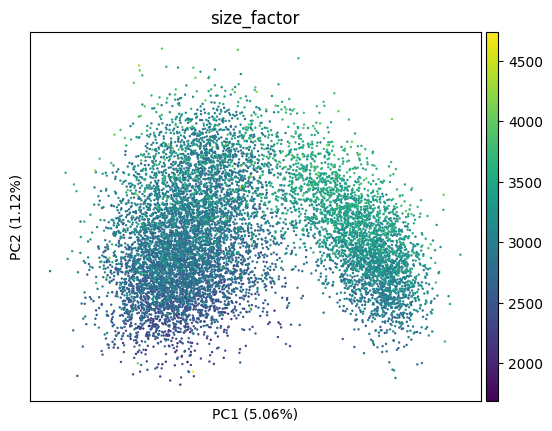

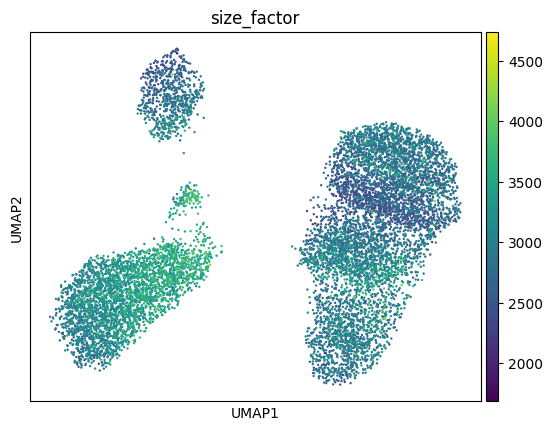

In [86]:
sc.pl.pca(adata_generated_rna, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated_rna, color="size_factor")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


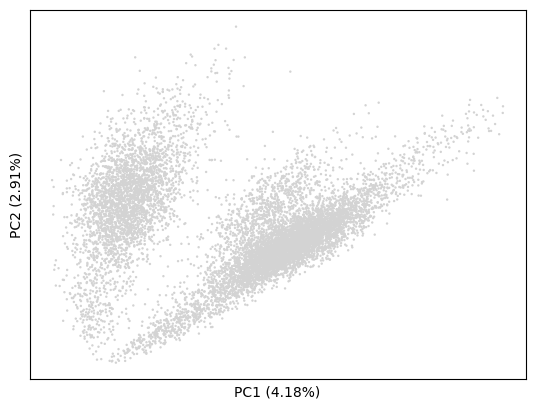

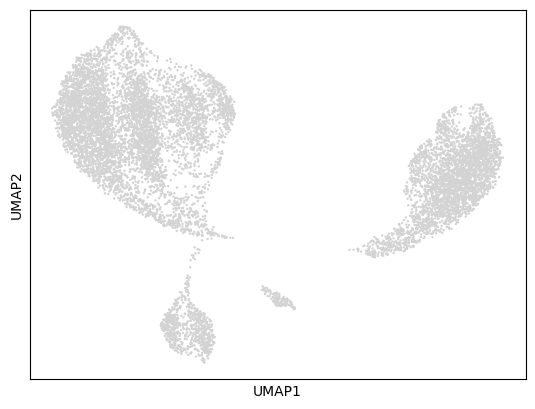

In [87]:
sc.pl.pca(adata_generated_atac, annotate_var_explained=True)
sc.pl.umap(adata_generated_atac)

Merge and plot the generated and real data

In [88]:
dataset_type_rna = ["Real" for _ in range(X_rna.shape[0])] + ["Generated" for _ in range(X_generated_rna_list.shape[0])]
dataset_type_rna = pd.DataFrame(dataset_type_rna)
dataset_type_rna.columns = ["dataset_type"]
dataset_type_rna["classes"] = list(adata_rna.obs.cell_type)+list(classes_str)

In [89]:
dataset_type_atac= ["Real" for _ in range(X_atac.shape[0])] + ["Generated" for _ in range(X_generated_atac_list.shape[0])]
dataset_type_atac = pd.DataFrame(dataset_type_atac)
dataset_type_atac.columns = ["dataset_type"]
dataset_type_atac["classes"] = list(adata_atac.obs.cell_type)+list(classes_str)

In [90]:
adata_merged_rna = sc.AnnData(X=torch.cat([X_rna, X_generated_rna_list], dim=0).numpy(), 
                             obs=dataset_type_rna)

adata_merged_atac = sc.AnnData(X=torch.cat([X_atac, X_generated_atac_list], dim=0).numpy(), 
                             obs=dataset_type_atac)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [91]:
sc.pp.log1p(adata_merged_rna) 
sc.tl.pca(adata_merged_rna)
sc.pp.neighbors(adata_merged_rna)
sc.tl.umap(adata_merged_rna)

## 

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


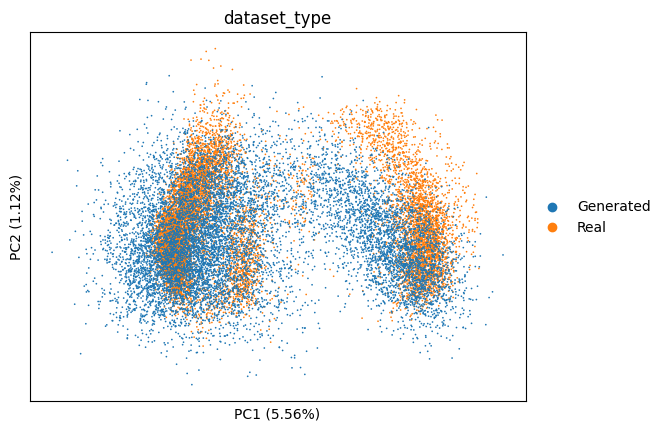

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

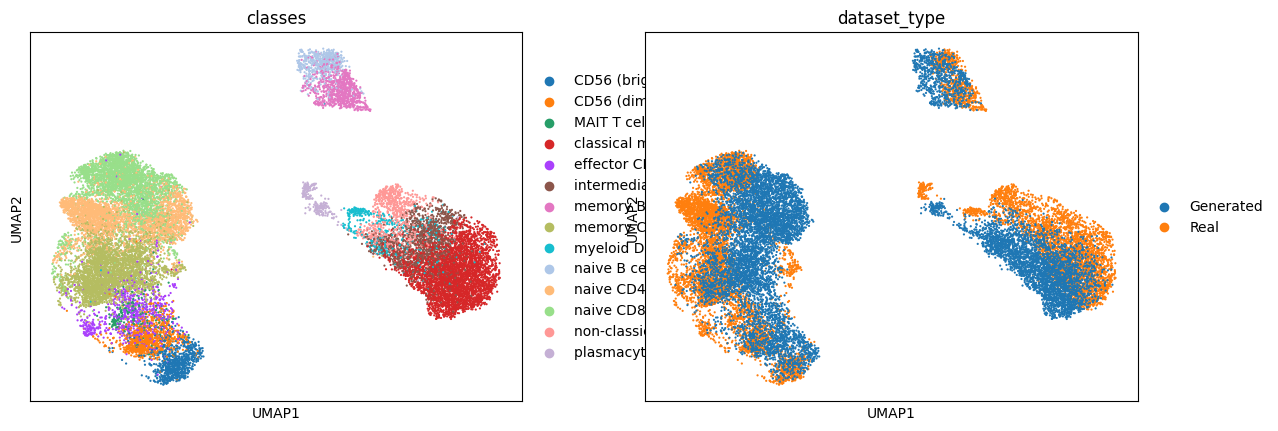

In [92]:
sc.pl.pca(adata_merged_rna, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged_rna, color=["classes","dataset_type"], s=10)

In [93]:
sc.pp.log1p(adata_merged_atac) 
sc.tl.pca(adata_merged_atac)
sc.pp.neighbors(adata_merged_atac)
sc.tl.umap(adata_merged_atac)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


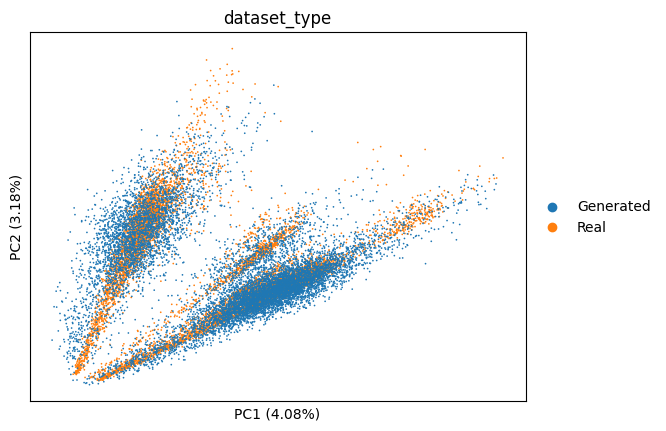

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

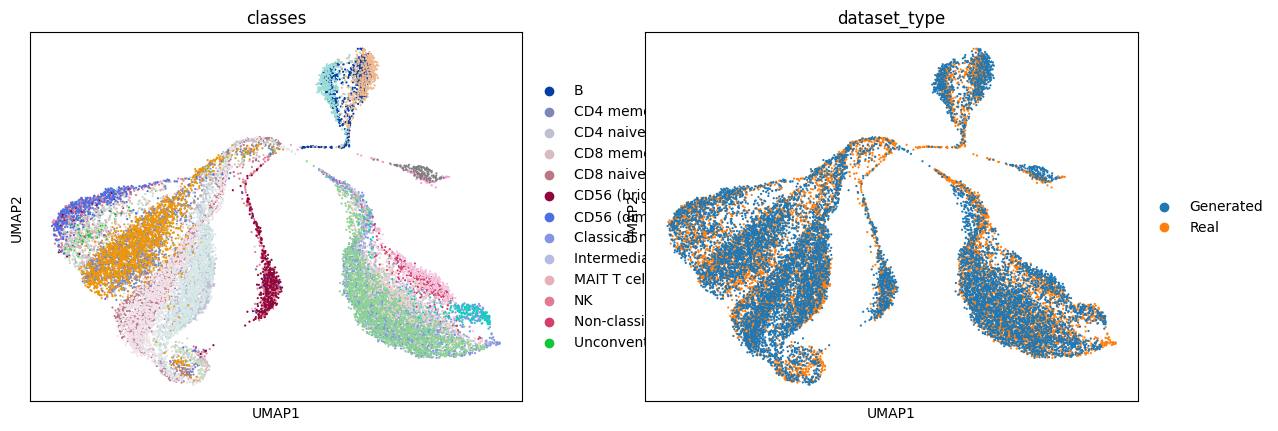

In [94]:
sc.pl.pca(adata_merged_atac, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged_atac, color=["classes","dataset_type"], s=10)

## Markers

In [95]:
adata_generated_atac.obs["cell_type"] = classes_str

In [96]:
adata_generated_atac.var = adata_atac.var.copy()

In [97]:
marker_peaks = [
    'chr14:99255246-99275454', 'chr10:33135632-33141841',                              # T/NK
    'chr1:1210271-1220028',                                                            # memory T/NK
    'chr2:86783559-86792275',                                                          # CD8+ T/NK
    'chr12:10552886-10555668',                                                         # naïve CD8+ T
    'chr11:114072228-114076352',                                                       # MAIT/NK
    # 'chr5:150385442-150415310',                                                        # B and mono (CD74)
    'chr22:41931503-41942227', 'chr22:41917087-41929835', 'chr6:167111604-167115345',  # B
    'chr9:107480158-107492721', 'chr5:1476663-1483241',                                # mono
    'chr10:75399596-75404660', 'chr1:220876295-220883526',                             # mDC
    'chr17:81425658-81431769'                              # pDC
]

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via '

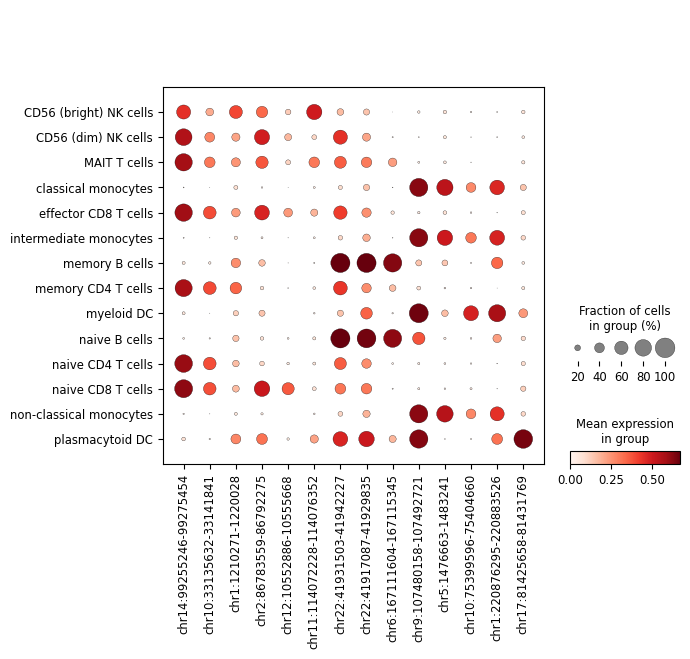

In [98]:
sc.pl.dotplot(adata_generated_atac, marker_peaks, 'cell_type')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via '

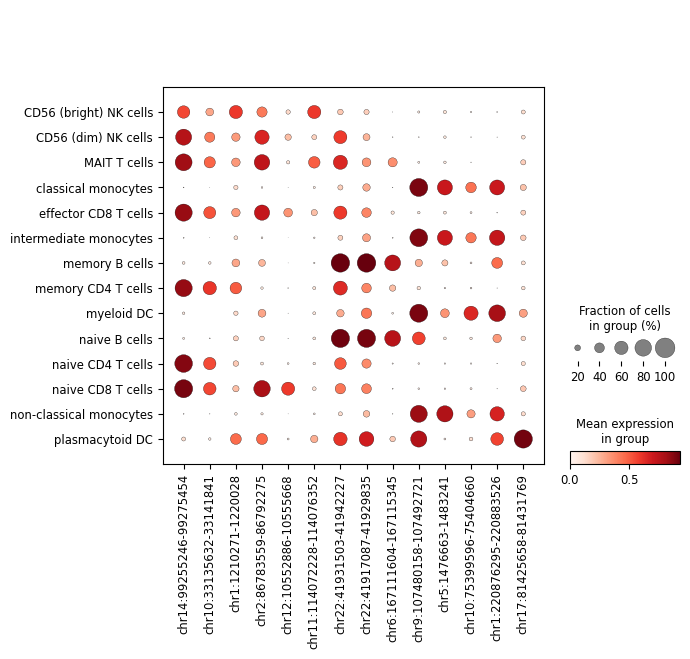

In [101]:
sc.pl.dotplot(adata_atac, marker_peaks, 'cell_type')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498:

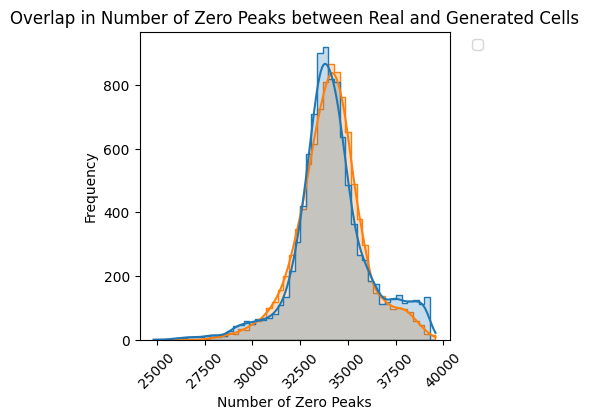

In [108]:
# Separate the number of zero genes for real and generated cells
import seaborn as sns

real_cells_zeros = list((adata_atac.X.A==0).sum(1))
generated_cells_zeros = list((adata_generated_atac.X.A==0).sum(1))

# Create a DataFrame for plotting with Seaborn
df = pd.DataFrame({
    'Number of zeros per cell': real_cells_zeros+generated_cells_zeros,
    'Dataset type': ["Real" for _ in range(len(real_cells_zeros))] + ["Generated" for _ in range(len(generated_cells_zeros))]
})

# Plot histogram using Seaborn
plt.figure(figsize=(4, 4))
sns.histplot(data=df, x='Number of zeros per cell', hue='Dataset type', element='step', bins=50, kde=True)
plt.xlabel('Number of Zero Peaks')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Overlap in Number of Zero Peaks between Real and Generated Cells')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [103]:
adata_generated_atac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'size_factor', 'cell_type'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [3]:
adata_atac

NameError: name 'adata_atac' is not defined